In [1]:
import jax
import infomec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, feature_selection, metrics, linear_model


In [2]:
def process_individually(xs, xs_type):
    processed_xs = []
    if xs_type == 'discrete':
        for i in range(xs.shape[1]):
            processed_xs.append(preprocessing.LabelEncoder().fit_transform(xs[:, i]))
        processed_xs = np.stack(processed_xs, axis=1)
    elif xs_type == 'continuous':
        for i in range(xs.shape[1]):
            processed_xs.append(preprocessing.StandardScaler().fit_transform(xs[:, i][:, None]))
        processed_xs = np.concatenate(processed_xs, axis=1)
    else:
        raise ValueError(f'Unknown xs type: {xs_type}')
    return processed_xs

def compute_cnmi(s, z, n_samples=1000):
    d_s = s.shape[1]
    d_z = z.shape[1]
    n = s.shape[0]
    cnmi = np.empty(shape=(d_s, d_z))
    s = process_individually(s, 'discrete')
    z = process_individually(z, 'discrete')
    for i_s in range(d_s):
        cnmi_samples = []
        for i_sample in range(n_samples):
            while True:
                s_sample = s[np.random.choice(n), :]
                mask = np.all(s[:, np.arange(d_s) != i_s] == s_sample[np.arange(d_s) != i_s], axis=1)
                s_slice = s[mask, :]
                entropy = metrics.mutual_info_score(s_slice[:, i_s], s_slice[:, i_s])
                if entropy > 0:
                    break
            z_slice = z[mask, :]
            cmi_sample = []
            for i_z in range(d_z):
                cmi_sample.append(metrics.mutual_info_score(s_slice[:, i_s], z_slice[:, i_z]))
            cmi_sample = np.array(cmi_sample)
            cnmi_samples.append(cmi_sample / entropy)
        cnmi[i_s, :] = np.mean(cnmi_samples, axis=0)
    return cnmi

def compute_cinfomec(sources, latents):
    cnmi = compute_cnmi(sources, latents)
    
    latent_ranges = np.max(latents, axis=0) - np.min(latents, axis=0)
    max_latent_range = np.max(latent_ranges)
    active_latents = latent_ranges > 0.1 * max_latent_range
    
    # latent_quantiles = np.quantile(latents, q=[0.25, 0.75], axis=0)
    # latent_iqr = latent_quantiles[1] - latent_quantiles[0]
    # max_latent_iqr = np.max(latent_iqr)
    # active_latents = latent_iqr > 0.1 * max_latent_iqr

    num_sources = sources.shape[1]
    num_active_latents = np.sum(active_latents)
    pruned_cnmi = cnmi[:, active_latents]
    if num_active_latents == 0:
        return {
            'cinfom':          0,
            'cinfoc':          0,
            'infoe':           0,
            'cnmi':            cnmi,
            'active_latents': active_latents,
        }

    cinfom = (np.mean(np.max(pruned_cnmi, axis=0) / np.sum(pruned_cnmi, axis=0)) - 1 / num_sources) / (
                1 - 1 / num_sources)
    cinfoc = (np.mean(np.max(pruned_cnmi, axis=1) / np.sum(pruned_cnmi, axis=1)) - 1 / num_active_latents) / (
                1 - 1 / num_active_latents)
    infoe = infomec.compute_infoe(sources, latents, 'discrete', 'discrete')

    return {
        'cinfom': cinfom,
        'cinfoc': cinfoc,
        'infoe': infoe,
        'cnmi': cnmi,
        'active_latents': active_latents,
    }

<Axes: >

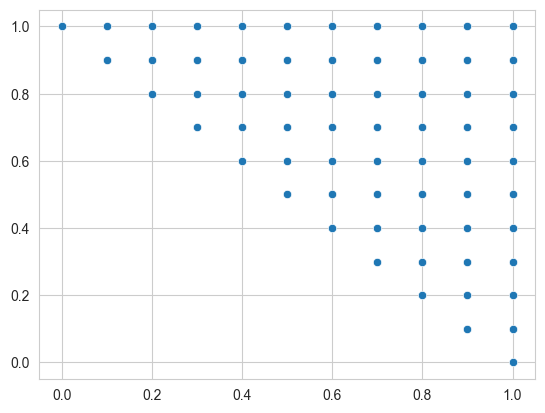

In [3]:
s = np.mgrid[0:1:11j, 0:1:11j]
s = s.reshape(2, -1).T
slice = 0.99
s = s[s[:, 1] > -s[:, 0] + slice]
sns.scatterplot(x=s[:, 0], y=s[:, 1])

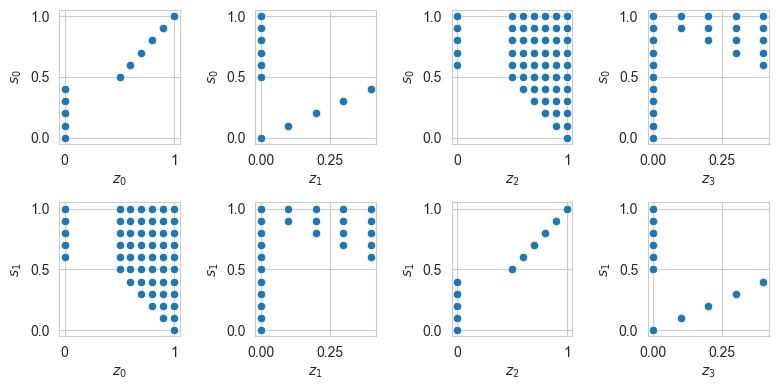

In [4]:
z0 = s[:, 0].copy()
z0[z0 < 0.5] = 0
z1 = s[:, 0].copy()
z1[z1 >= 0.5] = 0
z2 = s[:, 1].copy()
z2[z2 < 0.5] = 0
z3 = s[:, 1].copy()
z3[z3 >= 0.5] = 0
z = np.stack([z0, z1, z2, z3], axis=1)
ns = s.shape[1]
nz = z.shape[1]
fig, axes = plt.subplots(ns, nz, figsize=(2 * nz, 2 * ns))
for i in range(ns):
    for j in range(nz):
        ax = axes[i][j]
        sns.scatterplot(
            ax=ax,
            x=z[:, j],
            y=s[:, i],
            rasterized=True
        )
        ax.set_xlabel(rf'$z_{{{j}}}$')
        ax.set_ylabel(rf'$s_{{{i}}}$')
fig.tight_layout()

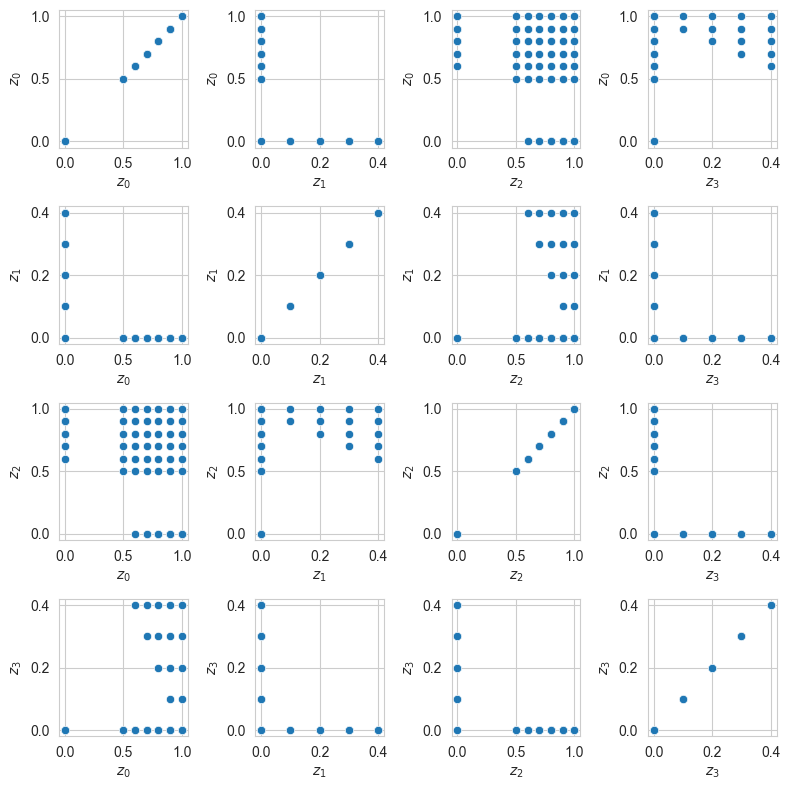

In [5]:
fig, axes = plt.subplots(nz, nz, figsize=(2 * nz, 2 * nz))
for i in range(nz):
    for j in range(nz):
        ax = axes[i][j]
        sns.scatterplot(
            ax=ax,
            x=z[:, j],
            y=z[:, i],
            rasterized=True,
        )
        ax.set_xlabel(rf'$z_{{{j}}}$')
        ax.set_ylabel(rf'$z_{{{i}}}$')
fig.tight_layout()

In [6]:
cinfomec = compute_cinfomec(s, z)
cinfomec

{'cinfom': 1.0,
 'cinfoc': 0.6727499883977917,
 'infoe': 0.9999155545918289,
 'cnmi': array([[0.8836292 , 0.2812315 , 0.        , 0.        ],
        [0.        , 0.        , 0.87774636, 0.29171784]]),
 'active_latents': array([ True,  True,  True,  True])}

In [7]:
infomec_ = infomec.compute_infomec(s, z, 'discrete', 'discrete')
infomec_

{'infom': 0.7312214675437889,
 'infoc': 0.4883797630903987,
 'infoe': 0.9999155545918289,
 'nmi': array([[0.84907047, 0.35646981, 0.10486531, 0.06731853],
        [0.10486531, 0.06731853, 0.84907047, 0.35646981]]),
 'active_latents': array([ True,  True,  True,  True])}